![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
# Celda 1
import numpy as np
import math
from collections.abc import ValuesView

# Definición de función para calcular el MSE
def mse(y):
    return ((y - y.mean())**2).mean()

# Definición de función de ganancia MSE
def mse_gain(X_col, y, split):
    filter_l = X_col < split
    filter_r = ~filter_l
    y_l = y[filter_l]
    y_r = y[filter_r]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    n = n_l + n_r
    w = n_l / n

    current_mse = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)

    return current_mse - w * mse_l - (1 - w) * mse_r

# Definición de la función cque calcula la mejor partición
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best = [0, 0, float('inf')]

    for j in features:
        splits = np.linspace(X.iloc[:, j].min(), X.iloc[:, j].max(), num_pct)
        splits = np.unique(splits)[1:]  # Evitar particiones vacías

        #Para cada partición
        for split in splits:
            gain = mse_gain(X.iloc[:, j], y, split)
            if gain < best[2]:
                best = [j, split, gain]
    return best

# Definición de la función que hace crecer el árbol
def tree_grow(X, y, level=0, max_depth=1, num_pct=10):
    # Si solo hay una observación
    if X.shape[0] == 1:
        return {
            'y_pred': y.iloc[0],  # Accede directamente al primer valor
            'level': level,
            'split': -1,
            'n_samples': 1,
            'rmse': math.inf
        }

    # Calcular la mejor división
    j, split, sc_rmse = best_split(X, y, num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    tree = {
        'y_pred': y_pred,
        'level': level,
        'split': -1,
        'n_samples': X.shape[0],
        'rmse': sc_rmse
    }

    # Revisar el criterio de parada
    if max_depth is not None and level >= max_depth:
        return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    filter_r = ~filter_l
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[filter_r], y.loc[filter_r]

    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['left'] = tree_grow(X_l, y_l, level + 1, max_depth, num_pct)
    tree['right'] = tree_grow(X_r, y_r, level + 1, max_depth, num_pct)

    return tree

# Definición de la función que predice
def tree_predict(X, tree):
    # Inicializar el arreglo de predicciones
    predicted = np.full(X.shape[0], tree['y_pred'])

    # Revisar si es el nodo final (nodo hoja)
    if tree['split'] == -1:
        return predicted
    else:
        j, split = tree['split']
        filter_l = X.iloc[:, j] < split
        filter_r = ~filter_l
        X_l = X.loc[filter_l]
        X_r = X.loc[filter_r]

        # Recursivamente predecir para los subconjuntos izquierdo y derecho
        if not X_l.empty:  # Asegurar que el subconjunto no esté vacío
            predicted[filter_l] = tree_predict(X_l, tree['left'])
        if not X_r.empty:  # Asegurar que el subconjunto no esté vacío
            predicted[filter_r] = tree_predict(X_r, tree['right'])

        return predicted

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Entrenamiento del modelo de árbol
tree = tree_grow(X_train, y_train, level=0, max_depth=10, num_pct=10)

# Predicción con el modelo de árbol y metricas del árbol manual
y_pred = tree_predict(X_test, tree)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular MAE
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 3895.562234186076
MAE: 3092.824272648114


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [7]:
# Celda 2
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

#Verificar que cada muestar es del tamaño del conjunto original X_train
len(samples[0])

7031

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

for i, sample in enumerate(samples):
    X_train_bag = X_train.iloc[sample]
    y_train_bag = y_train.iloc[sample]
    treereg.fit(X_train_bag, y_train_bag)
    y_pred.iloc[:,i] = treereg.predict(X_test)

for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', mean_squared_error(y_pred.iloc[:,i], y_test))

Árbol  0 tiene un error:  4586507.756514306
Árbol  1 tiene un error:  4563999.809420709
Árbol  2 tiene un error:  4505934.93037112
Árbol  3 tiene un error:  4356733.592400805
Árbol  4 tiene un error:  4702473.53805716
Árbol  5 tiene un error:  4468493.497653323
Árbol  6 tiene un error:  4528100.856019053
Árbol  7 tiene un error:  4771668.2248925455
Árbol  8 tiene un error:  4571502.269342764
Árbol  9 tiene un error:  4545839.838453538


In [9]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))
print(f'RMSE: {rmse}')

RMSE: 1796.4355868399332


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

Max features (log scale): 1
Max features (log scale): 1
Max features (log scale): 1
Max features (log scale): 1
Max features (log scale): 1
Max features (log scale): 1
Max features (log scale): 1
Max features (log scale): 2
Max features (log scale): 2
RMSE Scores: [3201.8946218726123, 3201.8946218726123, 3201.8946218726123, 3201.8946218726123, 3201.8946218726123, 3201.8946218726123, 3201.8946218726123, 2671.0127988157697, 2671.0127988157697]
MAE Scores: [2500.809053915107, 2500.809053915107, 2500.809053915107, 2500.809053915107, 2500.809053915107, 2500.809053915107, 2500.809053915107, 2074.9760882251453, 2074.9760882251453]


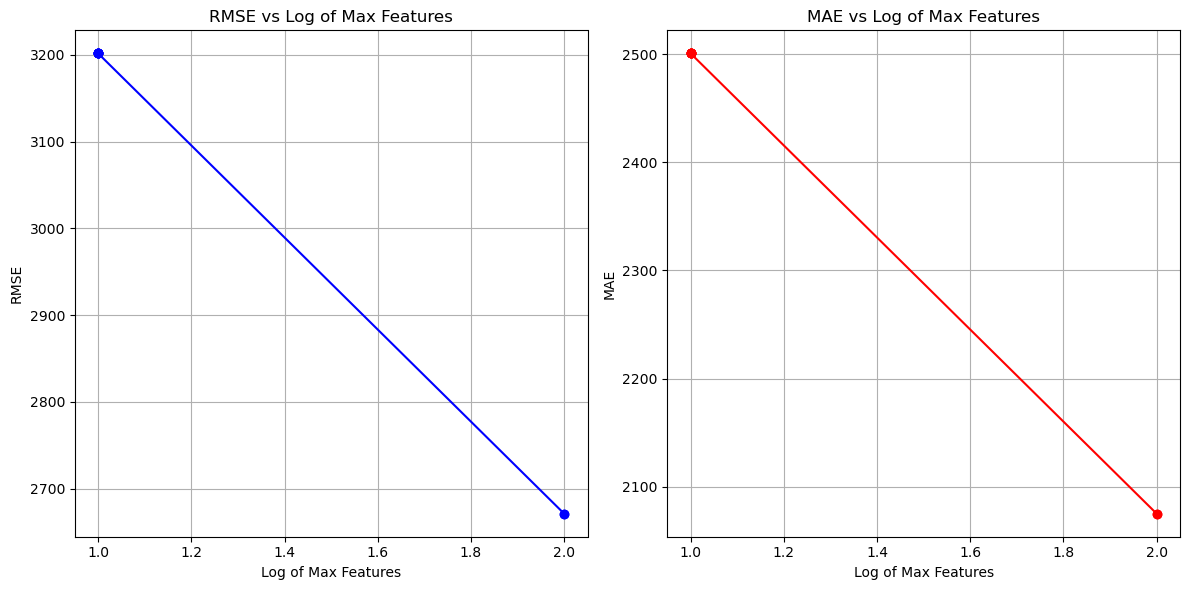

In [10]:
# Celda 2
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Crear una lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X_train.shape[1] + 1)

rmse_Bag_scores = []
msa_Bag_scores = []

# Iterar sobre cada valor de max_features
for n_features in feature_range:
    max_features = max(1, int(np.log(n_features)))  # Asegurarse que al menos siempre sea 1
    print("Max features (log scale):", max_features)

    # Crear el modelo de BaggingRegressor
    bagreg = BaggingRegressor(
        DecisionTreeRegressor(),
        n_estimators=10,
        max_features=max_features,
        bootstrap=True,
        oob_score=True,
        random_state=1
    )

    # Entrenar el modelo
    bagreg.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    y_pred_Bag2 = bagreg.predict(X_test)

    # Calcular y almacenar los errores RMSE y MAE
    rmse_Bag_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_Bag2)))
    msa_Bag_scores.append(mean_absolute_error(y_test, y_pred_Bag2))

# Imprimir los resultados
print("RMSE Scores:", rmse_Bag_scores)
print("MAE Scores:", msa_Bag_scores)

# Gráficos de RMSE y MAE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot([max(1, int(np.log(n))) for n in feature_range], rmse_Bag_scores, marker='o', linestyle='-', color='b')
plt.title('RMSE vs Log of Max Features')
plt.xlabel('Log of Max Features')
plt.ylabel('RMSE')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot([max(1, int(np.log(n))) for n in feature_range], msa_Bag_scores, marker='o', linestyle='-', color='r')
plt.title('MAE vs Log of Max Features')
plt.xlabel('Log of Max Features')
plt.ylabel('MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

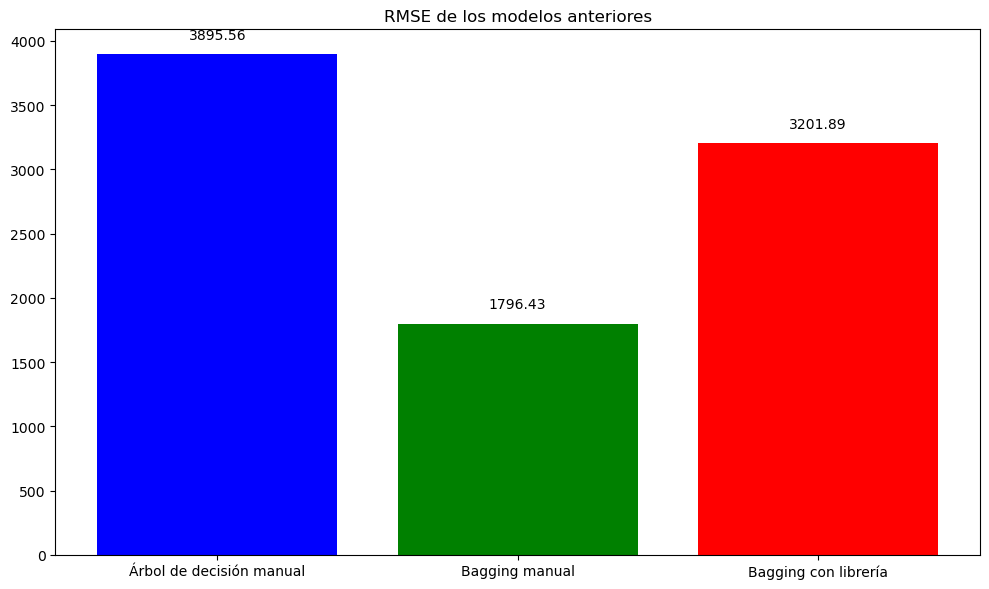

In [11]:
import matplotlib.pyplot as plt

methods = ['Árbol de decisión manual', 'Bagging manual', 'Bagging con librería']
values = [3895.56, 1796.43, 3201.89]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values, color=['blue', 'green', 'red'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, round(yval, 2), ha='center', va='bottom')

plt.title('RMSE de los modelos anteriores')
plt.xticks()
plt.tight_layout()

plt.show()

**Análisis:** Con base en los resultados anteriores, podemos observar que el desempeño de los modelos de Bagging con librerír y de Árbol de decisión manual son similiares en términos globales. El Bagging manual presenta un RMSE más bajo que los demas, teniendo en cuenta que se construyó de manera manual, el algoritmo no está optimizando y se pueden presentar errores que hacen que las métricas no sean lo suficientemente informativas. El baggin con librería funcionó mejor que el árbol de decisión manual posiblemente por la incluisión del parámetro max_features igual al logaritmo del conjunto de variables predictoras. Esto también se justifica en las gráficas presentadas, donde se ve que a mayor logaritmo, es decir, a mayor número de variables incluídas, el desempeño en términos de RMSE y MAE es mejor.



### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [12]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor

rfr= RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
print("RMSE Random Forest Regression:", rmse_rfr)
print("MAE Random Forest Regression:", mae_rfr)

RMSE Random Forest Regression: 1757.4790838730512
MAE Random Forest Regression: 1309.2108310607712


**Análisis:** Hasta el momento los resultados del RMSE y el MAE del modelo de Random Forest son los mejores ya que son menores a los de los otros modelos. Lo anterior, teniendo en cuenta que los modelos de Random Forest funcionan muy bien en una gran cantidad de escenarios.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

(2340482.2830608427, 8)


Text(0, 0.5, 'MSE')

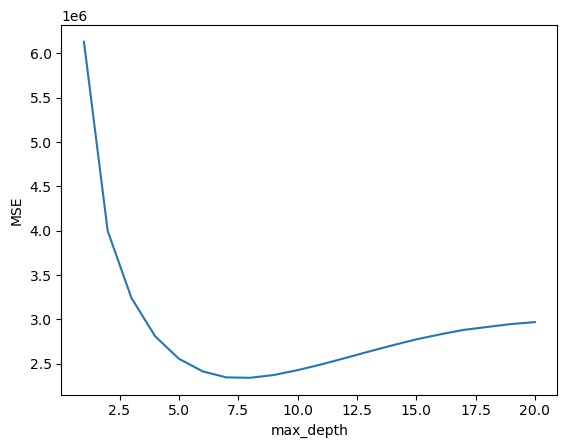

In [13]:
# Celda 5
from sklearn.model_selection import cross_val_score

max_depth_range = range(1, 21)
mse_scores = []

for depth in max_depth_range:
    clf = RandomForestRegressor(max_depth=depth, random_state=1)
    mse_scores.append((-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')).mean())

print(sorted(zip(mse_scores, max_depth_range))[::-1][-1])

plt.plot(max_depth_range, mse_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')

(3037100.1743315896, 9)


Text(0, 0.5, 'MSE')

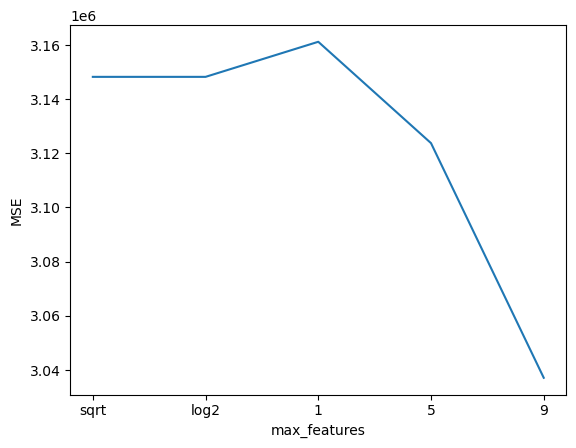

In [14]:
from sklearn.model_selection import cross_val_score

max_features_range = ["sqrt","log2",1,5,9]
mse_scores = []

for features in max_features_range:
    clf = RandomForestRegressor(max_features=features, random_state=1)
    mse_scores.append((-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')).mean())

print(sorted(zip(mse_scores, max_features_range))[::-1][-1])

plt.plot(max_features_range, mse_scores)
plt.xlabel('max_features')
plt.ylabel('MSE')

(3037100.1743315896, 10)


Text(0, 0.5, 'MSE')

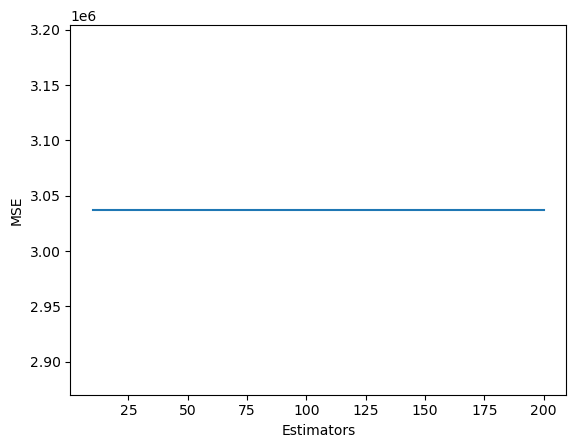

In [15]:
from sklearn.model_selection import cross_val_score

n_estimators_range = [10, 50, 100, 200]
mse_scores = []

for estimator in n_estimators_range:
    clf = RandomForestRegressor(max_features=estimator, random_state=1)
    mse_scores.append((-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')).mean())

print(sorted(zip(mse_scores, n_estimators_range))[::-1][-1])

plt.plot(n_estimators_range, mse_scores)
plt.xlabel('Estimators')
plt.ylabel('MSE')

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid={'max_depth': [None, 8,10, 20],
            'max_features':["sqrt","log2",1,5,10],
            'n_estimators': [10, 50, 100, 200]}

model = RandomForestRegressor()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_model

RandomForestRegressor(max_depth=8, max_features=5, n_estimators=50)

In [22]:
rfr_best=RandomForestRegressor(max_depth=8, max_features=5, n_estimators=50)
rfr_best.fit(X_train, y_train)
y_pred_rf = rfr_best.predict(X_test)

RMSE_RFR_best=np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("RMSE_RFR_BEST:",RMSE_RFR_best)

RMSE_RFR_BEST: 1554.9001422102544


**Análisis:** Con base en los resultados de las gráficas presentadas, en donde se calcula el MSE para cada uno de los parámetros en distintos rangos, se tiene que: 

* El MSE disminuye a medida que aumenta el max_depth, se estabiliza en 8 y luego vuelve a aumentar
* El MSE es mínimo cuando max_features incluye las 9 variables
* El valor del MES es constante para diferentes números de estimadores

Con base en la grilla calculada, se tiene que max_depth = 8, max_features=3 y n_estimators = 200. Lo anterior, arroja un RMSE igual a 1552.42 que es consistente en orden de magnitud con los otros modelos y es el mejor modelo hasta el momento. 


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [18]:
# Celda 6
from xgboost import XGBRegressor
xgr=XGBRegressor()
xgr.fit(X_train, y_train)
y_pred= xgr.predict(X_test)

RMSE_XGR=np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE_XGBoost:",RMSE_XGR)

RMSE_XGBoost: 1605.2355199928948


**Análisis:** Para este modelo de XGBoost sin calibración de parámetros, se tiene que el desempeño es menor al del modelo anterior, no siendo este el mejor de los modelos por el momento. Lo anterior, con base en la comparación del RMSE.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [19]:
# Celda 7
param_grid={'learning_rate': [0.2,0.1,0.01,0.001],
            'gamma':[0.01,0.1,0.2,0.3],
            'colsample_bytree': [0.4,0.6,0.8,1]}

model = XGBRegressor()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10,n_jobs=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
best_model.fit(X_train, y_train)
y_pred_rf =best_model.predict(X_test)

RMSE_XGB=np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("RMSE_XGB:",RMSE_XGB)

RMSE_XGB: 1547.6283952063602


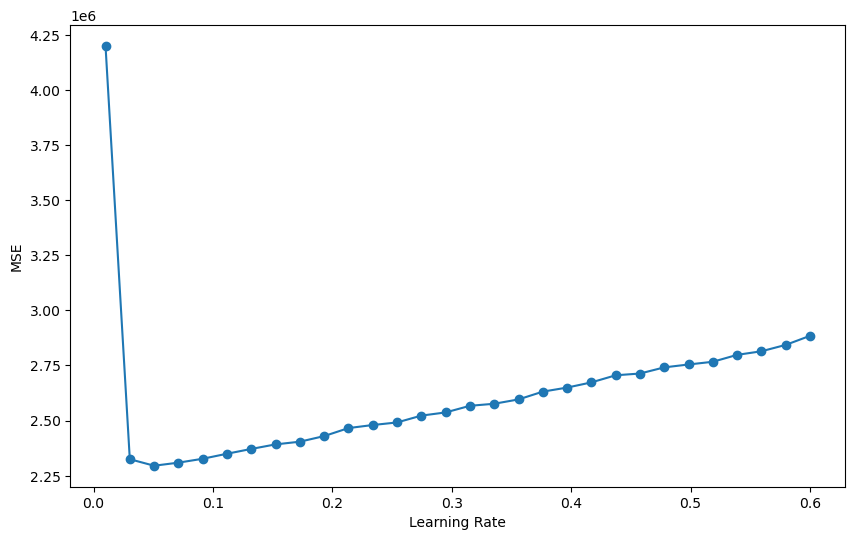

In [23]:
# Gráfica del MSE vs distintos valores del parámetro learning rate
from sklearn.model_selection import cross_val_score
import xgboost as xgb

learning_rates = np.linspace(0.01, 0.6, 30)

mse_scores = []

for lr in learning_rates:
    model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=lr)
    
    mse_score = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean()
    mse_scores.append(mse_score)

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, mse_scores, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.show()

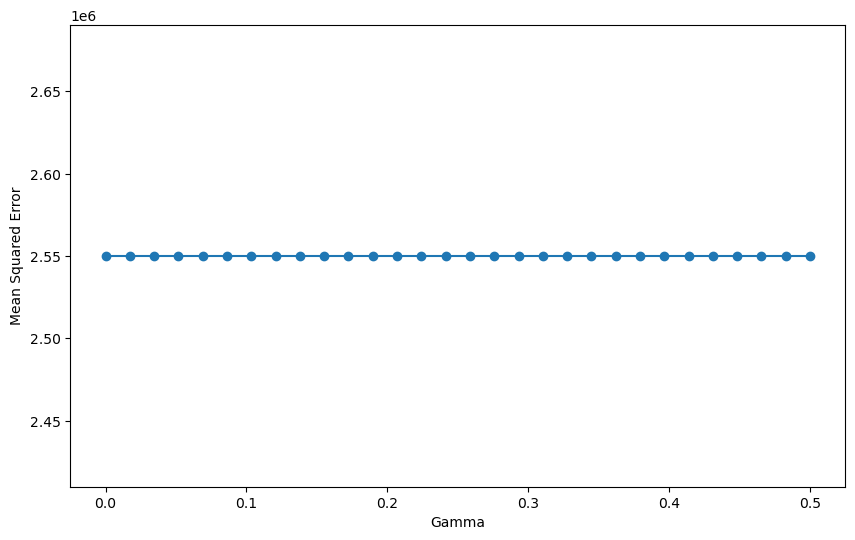

In [24]:
# Gráfica del MSE vs distintos valores del parámetro gamma
gamma_values = np.linspace(0, 0.5, 30)

mse_scores = []

for gamma in gamma_values:
    model = xgb.XGBRegressor(objective='reg:squarederror', gamma=gamma)
    
    mse_score = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean()
    mse_scores.append(mse_score)

# Plot gamma vs. MSE
plt.figure(figsize=(10, 6))
plt.plot(gamma_values, mse_scores, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Squared Error')
plt.show()

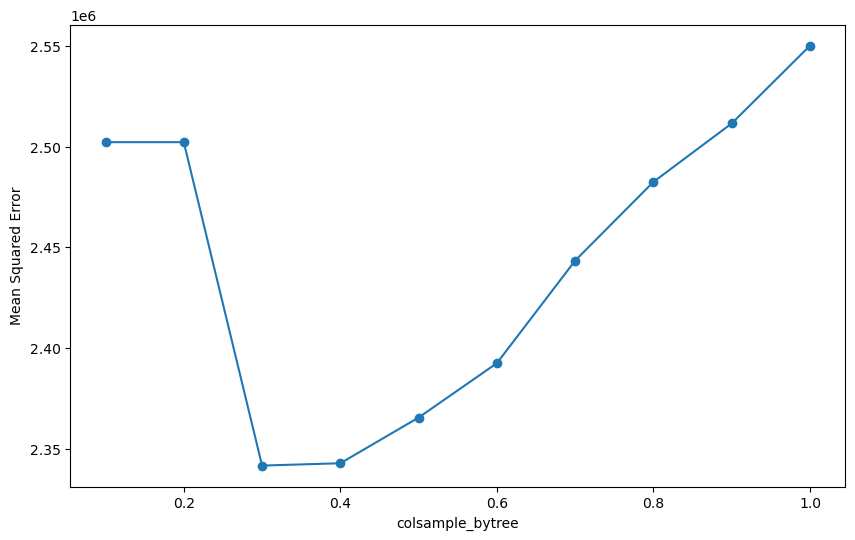

In [ ]:
# Gráfica del MSE vs distintos valores del parámetro colsample_bytree
colsample_bytree_values = np.linspace(0.1, 1, 10)

mse_scores = []

for colsample_bytree in colsample_bytree_values:
    model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=colsample_bytree)
    
    mse_score = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean()
    mse_scores.append(mse_score)


plt.figure(figsize=(10, 6))
plt.plot(colsample_bytree_values, mse_scores, marker='o')
plt.xlabel('colsample_bytree')
plt.ylabel('Mean Squared Error')
plt.show()


**Análisis:** Para distintos valores de los 3 parámetros que se indican en el cuestionario, se tiene que los valores óptimos obtenidos por inspección visual, son distintos a los que se hallaron usando la grilla del paquete Scikit-Learn. Para esta situación, no tenemos una explicación razonable aún. Con respecto del desempeño del modelo, usando los parámetros encontrados con la grilla se tiene que el RMSE para este es el menor hasta ahora calculado, por lo tanto, es el mejor modelo en términos de esta métrica. 

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

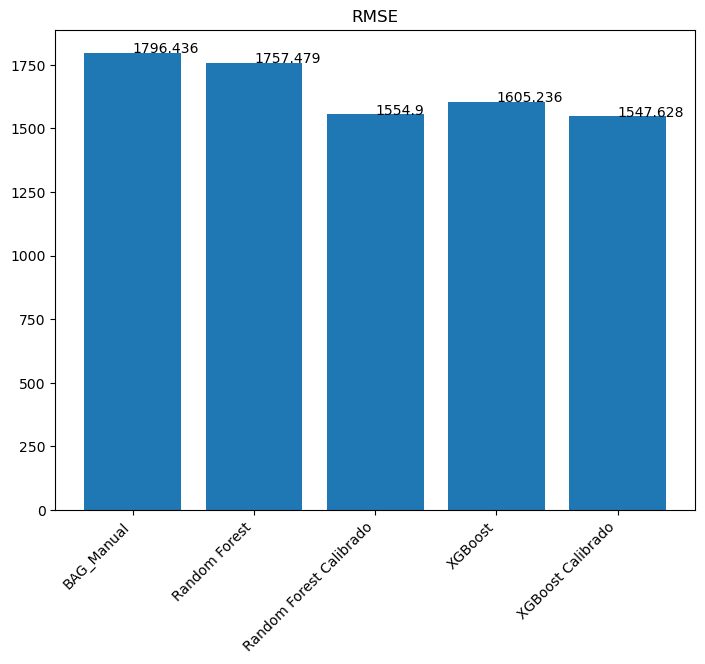

In [25]:
# Celda 8
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("RMSE")
ejeX = ['BAG_Manual', 
        'Random Forest',
        'Random Forest Calibrado',
        'XGBoost',
        'XGBoost Calibrado']
ejeY = [round(rmse,3), 
        round(rmse_rfr,3),
        round(RMSE_RFR_best,3),
        round(RMSE_XGR,3),
        round(RMSE_XGB,3)]
ax.bar(ejeX,ejeY)

ax.set_xticklabels(ejeX, rotation=45,ha='right')

def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)

plt.show()

**Análisis:** En términos de desempeño de los modelos, los dos modelos, tanto el XGBoost como el Random Forest en su versión con calibración de parámetros presentan los mejores desempeños, con una diferencia muy pequeña (casi 5 unidades). En términos de ventajas, se tiene que computacionalmente ya está construido y es relativamente fácil de calibrar y de interpretar. Con respecto de los modelos con "peor" desempeño, se tiene el de Bagging Manual. Para este modelo es difícil construir el código y se deben tener claros los conceptos tanto teóricos como de progración para lograrlo. 